In [42]:
# o código do gosdt usa várias funções antigas do sklearn,
# gerando muitas notificações; vamos desligar os warnings
# para 'limpar' a saída dessas mensagens
import warnings
warnings.filterwarnings('ignore')

In [43]:
import pandas as pd
import numpy as np
import pathlib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
# Alteração - correção dos nomes de pacotes
from gosdt.model.threshold_guess import compute_thresholds, cut
from gosdt import GOSDT
import joblib
import random
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

np.set_printoptions(threshold=np.inf)

In [44]:
# Fixando seed para replicabilidade
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

In [45]:
# read the dataset
df = pd.read_csv("../data/fico/fico.csv")
h = df.columns[:-1]
h

Index(['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance'],
      dtype='object')

In [46]:
# If train-test split is desired
X_train = joblib.load('../data/fico/X_train.joblib')
X_test = joblib.load('../data/fico/X_test.joblib')
y_train = joblib.load('../data/fico/y_train.joblib')
y_test = joblib.load('../data/fico/y_test.joblib')


#### 1. Threshold guess: we first use the gradient boosted tree to guess useful thresholds. 

In [47]:
# GBDT parameters for threshold and lower bound guesses
n_est = 40
max_depth = 1

In [48]:
# guess thresholds
X_train = pd.DataFrame(X_train, columns=h)
X_test = pd.DataFrame(X_test, columns=h)
X_train_guessed, thresholds, header, threshold_guess_time = compute_thresholds(X_train.copy(), y_train, n_est, max_depth)
X_test_guessed = cut(X_test.copy(), thresholds)
X_test_guessed = X_test_guessed[header]
print(X_train_guessed.shape)
print(X_test_guessed.shape)
print("train set column names == test set column names: {}".format(list(X_train_guessed.columns)==list(X_test_guessed.columns)))

(8367, 25)
(2092, 25)
train set column names == test set column names: True


#### 2. Lower bound guess: we use the gradient boosted tree to get labels for the training dataset. 

In [49]:
# guess lower bound
import time
start_time = time.perf_counter()
clf = GradientBoostingClassifier(n_estimators=n_est, max_depth=max_depth, random_state=random_state)
clf.fit(X_train_guessed, y_train)
warm_labels = clf.predict(X_train_guessed)

elapsed_time = time.perf_counter() - start_time

lb_time = elapsed_time

In [50]:
# save the labels as a tmp file and return the path to it.
labelsdir = pathlib.Path('./tmp/warm_lb_labels')
labelsdir.mkdir(exist_ok=True, parents=True)

labelpath = labelsdir / 'warm_label.tmp'
labelpath = str(labelpath)
pd.DataFrame(warm_labels).to_csv(labelpath, header="class_labels",index=None) # TODO: verify this formats correctly for gosdt (shouldn't require headers)


#### Train GOSDT model

In [51]:
# train GOSDT model
config = {
            "regularization": 0.001,
            "depth_budget": 5,
            "time_limit": 60,
            "warm_LB": True,
            "path_to_labels": labelpath,
            "similar_support": False
        }

model = GOSDT(config)

model.fit(X_train_guessed, pd.DataFrame(y_train))

print("evaluate the model, extracting tree and scores", flush=True)

gosdt reported successful execution
training completed. 0.000/0.000/1.524 (user, system, wall), mem=0 MB
bounds: [0.285638..0.285638] (0.000000) loss=0.277638, iterations=22366
evaluate the model, extracting tree and scores


#### Lendo instâncias selecionadas para análise

In [52]:
selected_instances = joblib.load('../data/fico/selected_instances.joblib')
instance_low = selected_instances['instance_low']
instance_medium = selected_instances['instance_medium']
instance_high = selected_instances['instance_high']

In [53]:
X_test

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,69,148,4,66,41,0,0,100,-7,7,...,10,-7,1,1,32,60,7,3,1,50
1,77,229,3,109,23,0,0,100,-7,7,...,35,0,0,0,38,93,4,3,1,58
2,58,46,7,38,13,0,0,93,8,4,...,50,-7,2,2,80,84,5,4,1,90
3,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
4,80,226,2,66,35,0,0,100,-7,7,...,47,0,0,0,2,77,5,7,0,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,63,97,9,44,9,7,6,71,58,6,...,29,0,4,4,69,-8,1,1,1,50
2088,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
2089,63,124,2,17,6,0,0,100,-7,7,...,40,-7,3,3,45,98,4,4,2,90
2090,56,124,5,63,23,2,2,72,2,4,...,62,0,1,1,8,89,2,4,0,86


In [54]:
instance_low_df = pd.DataFrame(columns=h, data=[instance_low])
print(model.predict(instance_low_df))
instance_low_df

[0]


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,80,226,2,66,35,0,0,100,-7,7,...,47,0,0,0,2,77,5,7,0,62


In [55]:
instance_medium_df = pd.DataFrame(columns=h, data=[instance_medium])
print(model.predict(instance_medium_df))
instance_medium_df

[0]


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,73,190,19,68,37,0,0,100,-7,7,...,7,0,0,0,41,-8,14,1,7,63


In [56]:
instance_high_df = pd.DataFrame(columns=h, data=[instance_high])
print(model.predict(instance_high_df))
instance_high_df

[0]


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,58,46,7,38,13,0,0,93,8,4,...,50,-7,2,2,80,84,5,4,1,90


In [57]:
# POR QUE TÃO POUCOS = 1?
np.sum(model.predict(X_test) == 1)


25

#### 4. Get results

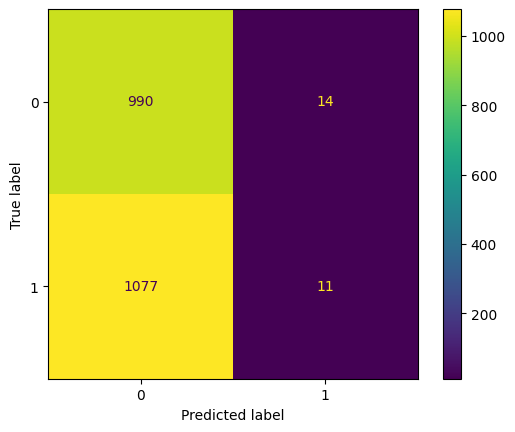

In [61]:
# matriz de confusão
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [62]:
# get the results
train_acc = model.score(X_train_guessed, y_train)
test_acc = model.score(X_test_guessed, y_test)
n_leaves = model.leaves()
n_nodes = model.nodes()
time = model.utime

print("Model training time: {}".format(time))
print("Training accuracy: {}".format(train_acc))
print("Test accuracy: {}".format(test_acc))
print("# of leaves: {}".format(n_leaves))
print(model.tree)

Model training time: 0.0
Training accuracy: 0.7223616588980518
Test accuracy: 0.7002868068833652
# of leaves: 8
if ExternalRiskEstimate<=65.5 = 1 and MSinceMostRecentInqexcl7days<=-7.5 = 1 then:
    predicted class: 1
    misclassification penalty: 0.026
    complexity penalty: 0.001

else if ExternalRiskEstimate<=65.5 != 1 and MSinceMostRecentInqexcl7days<=-7.5 = 1 then:
    predicted class: 0
    misclassification penalty: 0.006
    complexity penalty: 0.001

else if ExternalRiskEstimate<=75.5 = 1 and MSinceMostRecentInqexcl7days<=-7.5 != 1 and NumSatisfactoryTrades<=18.5 = 1 then:
    predicted class: 1
    misclassification penalty: 0.059
    complexity penalty: 0.001

else if ExternalRiskEstimate<=75.5 != 1 and MSinceMostRecentInqexcl7days<=-7.5 != 1 and NumSatisfactoryTrades<=18.5 = 1 then:
    predicted class: 0
    misclassification penalty: 0.043
    complexity penalty: 0.001

else if ExternalRiskEstimate<=74.5 = 1 and MSinceMostRecentInqexcl7days<=-7.5 != 1 and MSinceMostRece

As you can see, we find a reasonably accurate model quite quickly on datasets as complicated as FICO!

Thank you for reading our tutorial. Please do try out our methods with different parameters and datasets. Happy tree training!

# Não é o que o SKLEARN diz??

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision: {precision_score(y_test, y_pred):.2f}')
print(f'Recall: {recall_score(y_test, y_pred):.2f}')

Accuracy: 0.48
Precision: 0.44
Recall: 0.01
